In [26]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import cv2
from DataClasses import TextData, CircleData, MalenNachZahlenPunkt
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt

# Tesseract Wrapper

In [2]:
class TextBox:
    def __init__(self, text, x, y, w, h, conf):
        self.text = text
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.mid_x = int(x + w / 2.0)
        self.mid_y = int(y + h / 2.0)
        self.conf = conf

    def __str__(self):
        return '(Text: ' + self.text + ' x: ' + str(
            self.x) + ' y: ' + str(self.y) + ' w: ' + str(self.w) + ' h: ' + str(self.h) + ' conf: ' + str(
            self.conf) + ')'

    def __eq__(self, other):
        """
        A TextBox equals another if they have the same text inside
        """
        if self.text == other.text:
            return True
        else:
            return False


def detect_boxes(img, config):
    """
    Detects boxes of text in an image. The actual detection is done via tesseract.
    For more information on parameters and configuration see:
    https://github.com/tesseract-ocr/tesseract/wiki/ImproveQuality
    """
    # using the legacy engine requires downloading train data from
    # https://github.com/tesseract-ocr/tessdata
    data = pytesseract.image_to_data(img, config=config,
                                     output_type=Output.DICT)

    boxes = []
    n_boxes = len(data['level'])
    for i in range(n_boxes):
        conf = float(data['conf'][i])
        text = data['text'][i]
        if conf > 30 and text != u'0' and text.isdigit():
            (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
            box = TextBox(text, x, y, w, h, conf)
            if box in boxes:
                # Handle duplicates, take the box with the higher confidence
                for b2 in boxes:
                    if box == b2 and box.conf > b2.conf:
                        boxes.remove(b2)
                        boxes.append(box)
            else:
                # Just append
                boxes.append(box)

    return boxes

In [3]:
img_dir = Path('/Users/Johannes/Desktop/SS-19/Projektseminar-Regelungstechnik/projektseminar-regelungstechnik/data/test-images')

In [4]:
config = '-c tessedit_char_whitelist=0123456789 --psm 6 --oem 0'

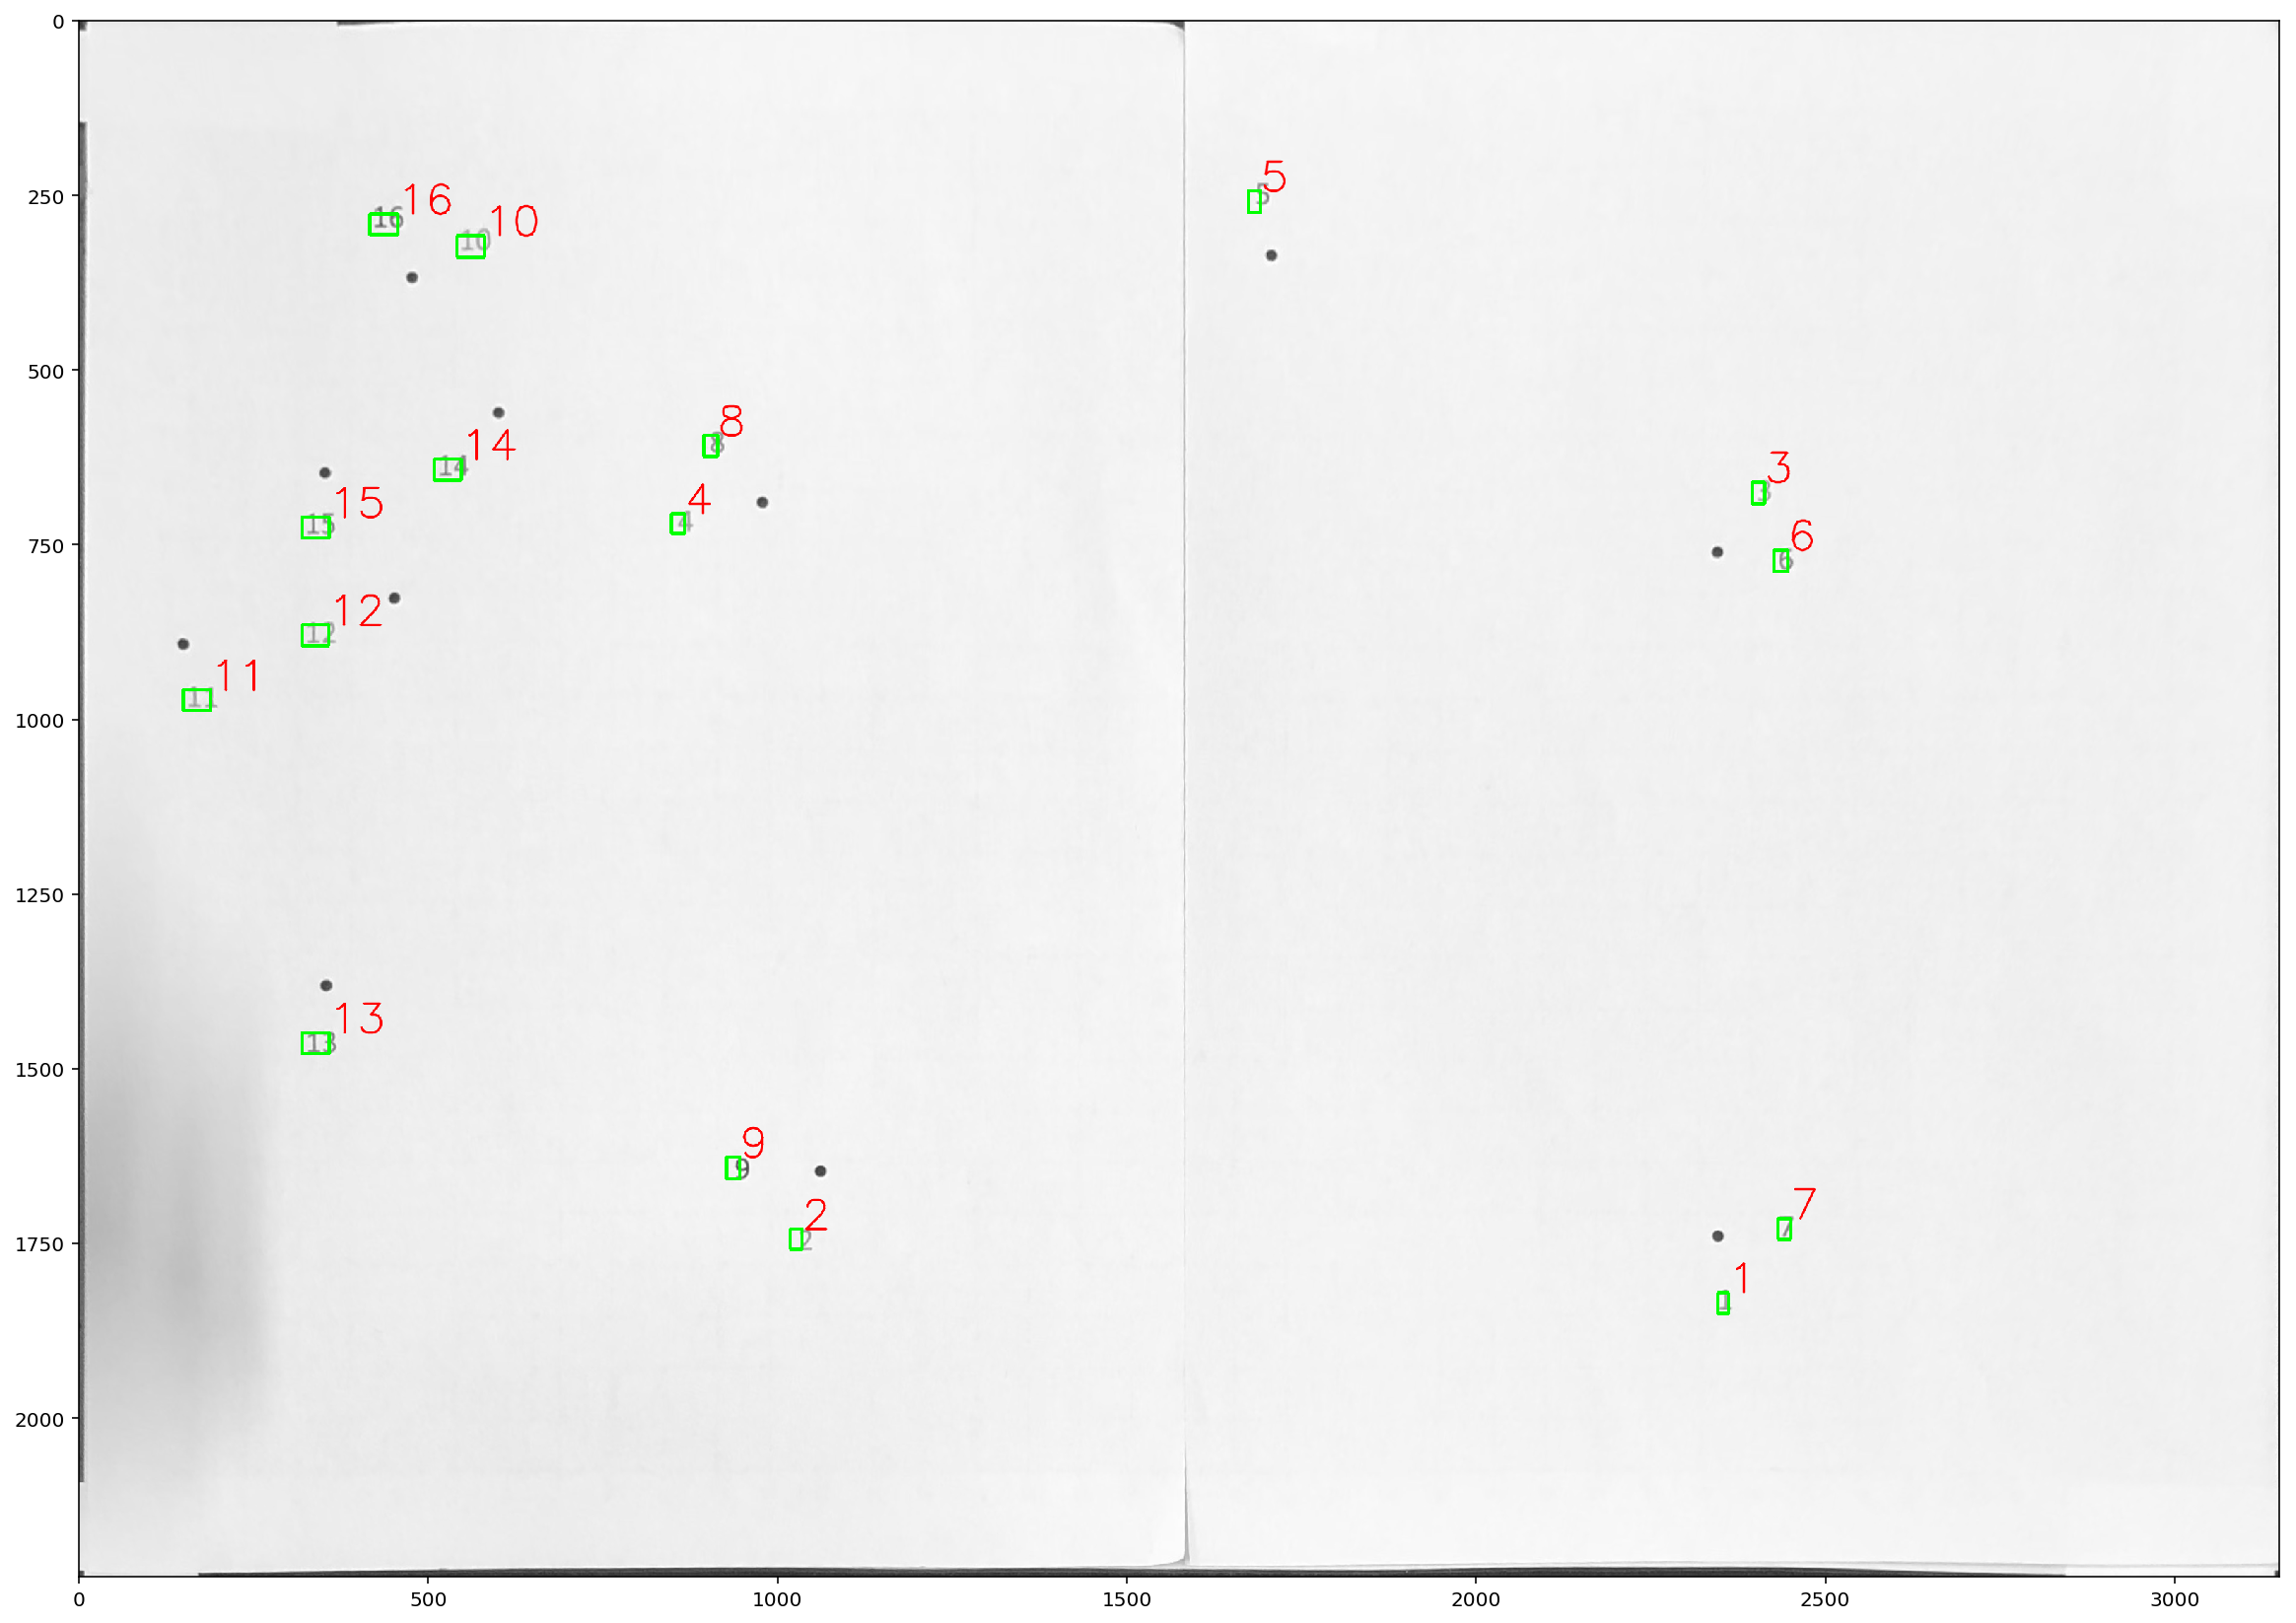

In [80]:
img_path = img_dir/'test-color-10.jpg-bird-eye.png'
img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

thres = cv2.adaptiveThreshold(bl,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,41,30)
thres = cv2.medianBlur(thres, 5)

text_boxes = detect_boxes(thres, config)
_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for t in text_boxes:
    cv2.putText(_img, t.text, (t.x + t.w, t.y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.rectangle(_img, (t.x, t.y), (t.x + t.w, t.y + t.h), (0, 255, 0), 4)

plt.figure(figsize=(20,22))
plt.imshow(_img, cmap='gray')

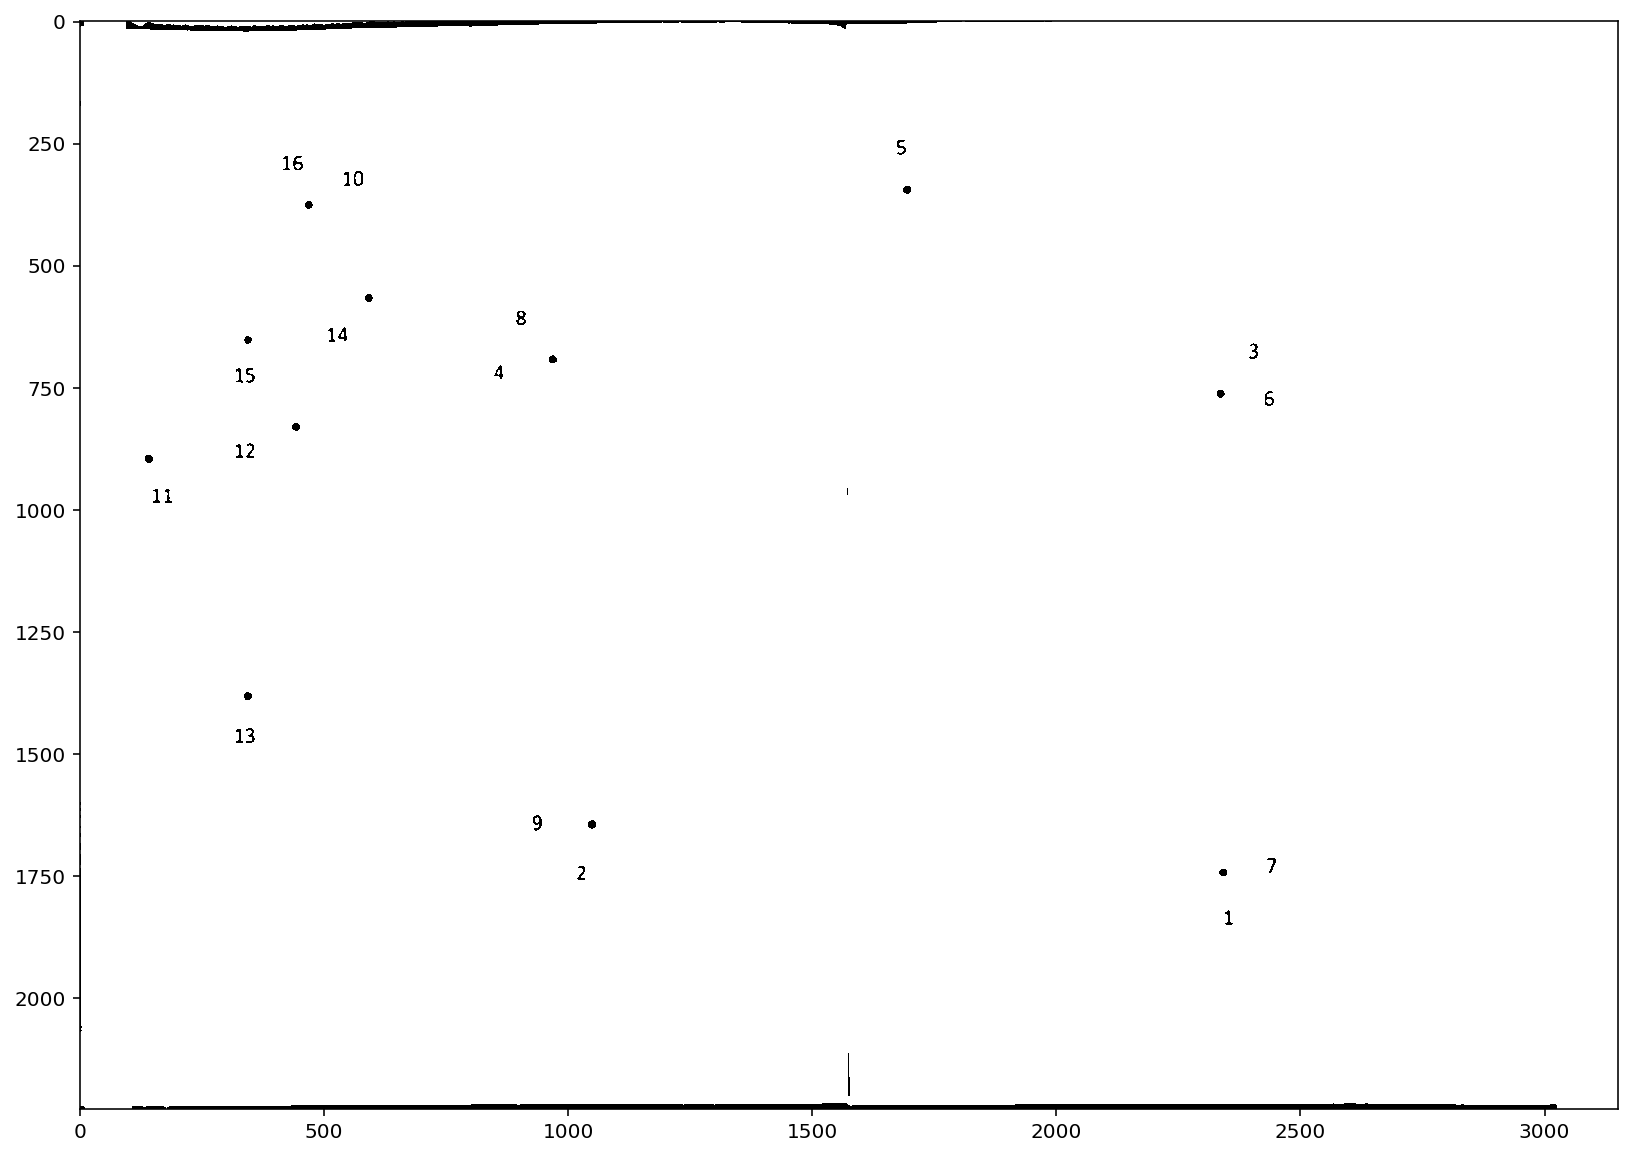

In [76]:
bl = img
thres = cv2.adaptiveThreshold(bl,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,41,30)
pbl = cv2.medianBlur(thres, 5)
plt.figure(figsize=(14, 10))
roi = pbl[500:1000,100:500]
plt.imshow(pbl, cmap='gray')

In [29]:
methods = [cv2.ADAPTIVE_THRESH_MEAN_C, cv2.ADAPTIVE_THRESH_GAUSSIAN_C]
block_sizes = range(3,60,6)

for (idx_method,method) in enumerate(methods):
    for  (idx_block_size, block_size) in enumerate(block_sizes):
        thres = cv2.adaptiveThreshold(img,255,method,cv2.THRESH_BINARY,block_size,0)
        roi = thres[250:1000,0:1000]
        cv2.imwrite(str(Path.home().absolute()/'Desktop'/'test'/'{}-{}.png'.format(method, block_size)), roi)

In [32]:
cs = range(0,60,5)

for c in cs:
    thres = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,31,c)
    roi = thres[250:1000,0:1000]
    cv2.imwrite(str(Path.home().absolute()/'Desktop'/'test'/'{}.png'.format(c)), roi)

In [39]:
methods = [cv2.ADAPTIVE_THRESH_MEAN_C, cv2.ADAPTIVE_THRESH_GAUSSIAN_C]
block_sizes = range(3,60,6)
cs = range(0,40,2)

n_detected = np.zeros((len(methods), len(block_sizes), len(cs)))
for (idx_method,method) in enumerate(methods):
    for  (idx_block_size, block_size) in enumerate(block_sizes):
        for (idx_c, c) in enumerate(cs):
            thres = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,31,7)
            boxes = detect_boxes(thres,config=config)
            n_detected[idx_method, idx_block_size, idx_c] = len(boxes)